<a href="https://colab.research.google.com/github/jproctor-rebecca/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/LS_DS_212_assignment_RJProctor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/validation split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv',
                 parse_dates=['created'],
                 index_col='created')
assert df.shape == (49352, 33)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]


In [3]:
# assign data to clearly labeled DataFrame
apartments = df

# drop NaNs
apartments.dropna(inplace=True)


In [4]:
# convert to date time format
#apartments['created'] = pd.to_datetime(apartments['created'], 
 #                                      infer_datetime_format=True)


#### EDA

In [5]:
apartments.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47260 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             47260 non-null  float64
 1   bedrooms              47260 non-null  int64  
 2   description           47260 non-null  object 
 3   display_address       47260 non-null  object 
 4   latitude              47260 non-null  float64
 5   longitude             47260 non-null  float64
 6   price                 47260 non-null  int64  
 7   street_address        47260 non-null  object 
 8   interest_level        47260 non-null  object 
 9   elevator              47260 non-null  int64  
 10  cats_allowed          47260 non-null  int64  
 11  hardwood_floors       47260 non-null  int64  
 12  dogs_allowed          47260 non-null  int64  
 13  doorman               47260 non-null  int64  
 14  dishwasher            47260 non-nul

In [6]:
apartments.head()


,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


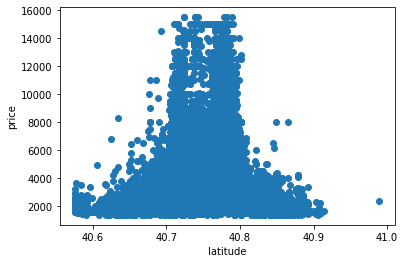

In [7]:
import matplotlib.pyplot as plt

plt.scatter(apartments['latitude'],
            apartments['price'], )
plt.xlabel('latitude')
plt.ylabel('price');

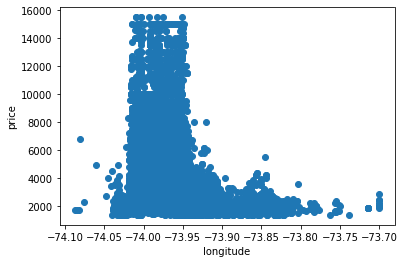

In [8]:
import matplotlib.pyplot as plt

plt.scatter(apartments['longitude'],
            apartments['price'], )
plt.xlabel('longitude')
plt.ylabel('price');

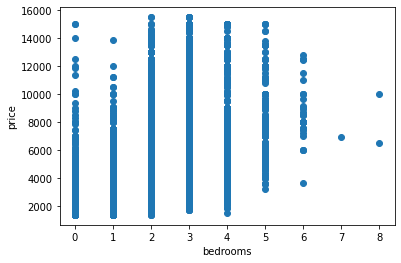

In [9]:
import matplotlib.pyplot as plt

plt.scatter(apartments['bedrooms'],
            apartments['price'], )
plt.xlabel('bedrooms')
plt.ylabel('price');

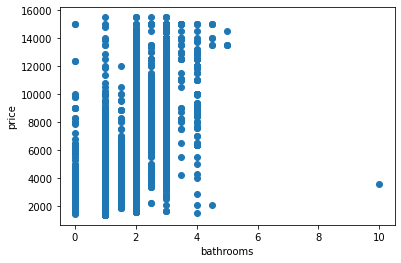

In [10]:
import matplotlib.pyplot as plt

plt.scatter(apartments['bathrooms'],
            apartments['price'], )
plt.xlabel('bathrooms')
plt.ylabel('price');

#### Feature Engineering

In [11]:
# reindex by 'created'
#apartments = apartments.set_index('created')
#apartments.head()


In [12]:
# concatenating the columns 
apartments['location'] = apartments['latitude'] + apartments['longitude']
print(apartments['location'])

created
2016-06-24 07:54:24   -33.2280
2016-06-12 12:19:27   -33.1720
2016-04-17 03:26:41   -33.2630
2016-04-18 02:22:02   -33.2138
2016-04-28 01:32:41   -33.1252
                        ...   
2016-06-02 05:41:05   -33.2364
2016-04-04 18:22:34   -33.3061
2016-04-16 02:13:40   -33.2299
2016-04-08 02:13:33   -33.3035
2016-04-12 02:48:07   -33.0473
Name: location, Length: 47260, dtype: float64


In [13]:
# concatenating the columns 
apartments['total_rooms'] = apartments['bedrooms'] + apartments['bathrooms']
print(apartments['total_rooms'])

created
2016-06-24 07:54:24    4.5
2016-06-12 12:19:27    3.0
2016-04-17 03:26:41    2.0
2016-04-18 02:22:02    2.0
2016-04-28 01:32:41    5.0
                      ... 
2016-06-02 05:41:05    3.0
2016-04-04 18:22:34    2.0
2016-04-16 02:13:40    2.0
2016-04-08 02:13:33    1.0
2016-04-12 02:48:07    3.0
Name: total_rooms, Length: 47260, dtype: float64


In [14]:
apartments.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,location,total_rooms
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-33.2280,4.5
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-33.1720,3.0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-33.2630,2.0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-33.2138,2.0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-33.1252,5.0


#### Test/Validation Split

In [15]:
# create the 2D features matrix
X = apartments[['location','total_rooms']]

# create the target array
y = apartments['price']

print(X.shape)
print(y.shape)


(47260, 2)
(47260,)


In [16]:
#TrainStart = '2016-04-01 00:00:00'	
#TrainEnd = '2016-05-31 23:59:59'
#TestStart = '2016-06-01 00:00:00'
#TestEnd = '2016-06-30 23:59:59'

In [17]:
# split dataset into Training and Validation sets
# time series split
cutoff = '2016-05-31' # 23:59:59
mask = X.index < '2016-05-31' # 23:59:59
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]


In [18]:
print(mask)

[False False  True ...  True  True  True]


In [19]:
print(X_train)
print(y_train)


                     location  total_rooms
created                                   
2016-04-17 03:26:41  -33.2630          2.0
2016-04-18 02:22:02  -33.2138          2.0
2016-04-28 01:32:41  -33.1252          5.0
2016-04-19 04:24:47  -33.2599          6.0
2016-04-27 03:19:56  -33.1648          3.0
...                       ...          ...
2016-04-22 15:44:11  -33.2573          2.0
2016-04-04 18:22:34  -33.3061          2.0
2016-04-16 02:13:40  -33.2299          2.0
2016-04-08 02:13:33  -33.3035          1.0
2016-04-12 02:48:07  -33.0473          3.0

[30801 rows x 2 columns]
created
2016-04-17 03:26:41    2850
2016-04-18 02:22:02    3275
2016-04-28 01:32:41    3350
2016-04-19 04:24:47    7995
2016-04-27 03:19:56    3600
                       ... 
2016-04-22 15:44:11    4500
2016-04-04 18:22:34    3950
2016-04-16 02:13:40    2595
2016-04-08 02:13:33    3350
2016-04-12 02:48:07    2200
Name: price, Length: 30801, dtype: int64


#### Establish Baseline

In [20]:
# baseline 
y_train.mean()


3573.3789162689523

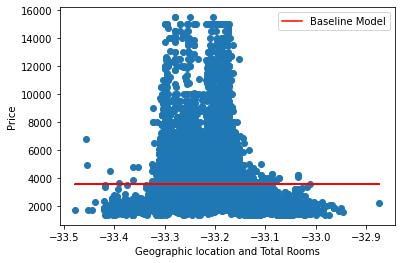

In [21]:
# map baseline model
# define initial/overlaying  parameters
col = ['location']

# get the mean value for the length of dataset 
y_pred = [y_train.mean()]*len(X_train) 

# create raw data plot
plt.scatter(X_train[col], y_train)

# create baseline plot
plt.plot(X_train[col], 
         y_pred, 
         color='red', 
         label='Baseline Model')
            # define model as baseline for linear regression as on 
            # training data
            
# define feature/properties parameters of plot(s)
plt.xlabel('Geographic location and Total Rooms')
plt.ylabel('Price')

# create legend and show plot(s)
plt.legend()
plt.show()


In [22]:
from sklearn.metrics import mean_absolute_error

print('Baseline MAE: ', mean_absolute_error(y_train, y_pred))


Baseline MAE:  1202.4941171064809


#### Build Model

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()            # instantiate model
model.fit(X_train[col], y_train)      # fit model to training data
y_pred = model.predict(X_train[col]) # make predictions


In [28]:
# Slope (also called the model coefficient)
print(model.coef_)

# Intercept
print(model.intercept_)

# Print in equation form
#print(f'\nprice = ({model.coef_[0]} * location) + ({model.coef_[1]} * total rooms) + ({model.intercept_})')


[-5050.5888166]
-164218.3142487573


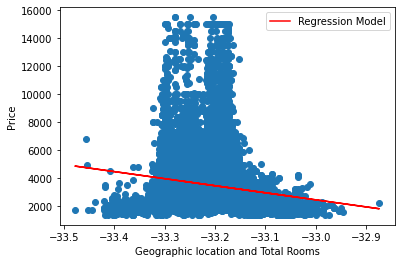

In [29]:
# map regression model
# define initial/overlaying  parameters
col = ['location']

# get the mean value for the length of dataset 
#y_pred = [y_train.mean()]*len(X_train) 

# create raw data plot
plt.scatter(X_train[col], y_train)

# create baseline plot
plt.plot(X_train[col], 
         y_pred, 
         color='red', 
         label='Regression Model')
            # define model as Regression Model for linear regression as on 
            # training data
            
# define feature/properties parameters of plot(s)
plt.xlabel('Geographic location and Total Rooms')
plt.ylabel('Price')

# create legend and show plot(s)
plt.legend()
plt.show()

#### Check Metrics


In [ ]:
# Mean Absolute Error (MAE)
from sklearn.metrics import mean_absolute_error

print('Training MAE: ', mean_absolute_error(y_train, model.predict(X_train[[col]])))
print('Validation MAE: ', mean_absolute_error(y_val, model.predict(X_val[[col]])))

###This error occurs when there are spaces in the column names but I can't find any###
###I cannot get any of the metrics to work###

In [ ]:
# Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error

print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train[[col]]), squared=False))
print('Validation RMSE:', mean_squared_error(y_val, model.predict(X_val[[col]]), squared=False))


In [ ]:
# R^2
from sklearn.metrics import r2_score

print('Training R2:', model.score(X_train[[col]], y_train))
print('Validation R2:', model.score(X_val[[col]], y_val))


#### Multiple Linear Regression


In [38]:
# pass data through your model a second time to account for noise of multiple variables
model2 = LinearRegression()         # instantiate
model2.fit(X_train, y_train)         # fit model to training data


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# check metrics
# Mean Absolute Error (MAE)
print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train[[col]])))
print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val[[col]])))

print()

# Root Mean Squared Error (RMSE)
print('Training RMSE:', mean_squared_error(y_train, model.predict(X_train[[col]]), squared=False))
print('Validation RMSE:', mean_squared_error(y_val, model.predict(X_val[[col]]), squared=False))

print()

# R^2 score
print('Training R2:', model2.score(X_train, y_train))
print('Training R2:', model2.score(X_val, y_val))


### Stretch 1

#### Simple Linear Regression

The ***RSME (RSE)*** it is the average amount that the response
will deviate from the true regression line.

The RSE is considered a measure of the lack of fit of the model (3.5) to
the data. If the predictions obtained using the model are very close to the
true outcome values.  If the values are small then the model fits the data very well.

On
the other hand, if ˆyi is very far from yi for one or more observations, then
the RSE may be quite large, indicating that the model doesn’t fit the data
well.

The ***R^2*** statistic provides an alternative
measure of fit. It takes the form of a proportion, the proportion of variance
explained, and so it always takes on a value between 0 and 1, and is
independent of the scale of Y .

R^2 measures the proportion
of variability in Y that can be explained using X. An R^2 statistic that is
close to 1 indicates that a large proportion of the variability in the response
has been explained by the regression. 

A number near 0 indicates that the
regression did not explain much of the variability in the response; this might
occur because the linear model is wrong, or the inherent error σ2 is high,
or both.

#### Multiple Linear Regression

Instead of fitting a separate simple linear regression model for each predictor,
a better approach is to extend the simple linear regression model
(3.5) so that it can directly accommodate multiple predictors. We can do
this by giving each predictor a separate slope coefficient in a single model.
In general, suppose that we have p distinct predictors. Then the multiple
linear regression model takes the form

Y = β0 + β1X1 + β2X2 + · · · + βpXp + ,

where Xj represents the jth predictor and βj quantifies the association
between that variable and the response. We interpret βj as the average
effect on Y of a one unit increase in Xj , holding all other predictors fixed.

As was the case in the simple linear regression setting, the regression coefficients
β0, β1, . . . , βp in are unknown, and must be estimated.
The parameters are estimated using the same least squares approach that
we saw in the context of simple linear regression. We choose β0, β1, . . . , βp
to minimize the sum of squared residuals.

When we perform multiple linear regression, we usually are interested in
answering a few important questions.
1. Is at least one of the predictors X1,X2, . . . , Xp useful in predicting
the response?
2. Do all the predictors help to explain Y , or is only a subset of the
predictors useful?
3. How well does the model fit the data?
4. Given a set of predictor values, what response value should we predict,
and how accurate is our prediction?



### Stretch 2

#### Statistics 101: Linear Regression, The Very Basics

simple linear regression
model mathematically the relationship bewteen two variables
good fit-compares relationship of one model with another model

begin with a sample

scatter plot y variable (sample)

with only one variable - mean of y(dependant var/sample var) is best predictor of best-fit line 

measure each data point distance from mean-line (line of best-fit/observed values) - standard deviation or residuals/errors

the residuals/errors always add up to zero

square the residuals/errors (makes them all positive, emphasizes all deviations), sum the squared residuals/errors (SSE)

sum_of_squares = the goal of simple linear regression is to create a linear model that minimizes (area) the sum of squares of the risiduals/errors(SSE)

A regression line with a good-fit will minimize the residuals/errors(SSE) so the SSE will be smaller than the original sum_of_squares.
